<a href="https://colab.research.google.com/github/zevy613/Project-2/blob/main/Project2_Part4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Loading, Inspecting and Visualizing Raw Data

In [123]:
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, classification_report, ConfusionMatrixDisplay, plot_confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

from sklearn import set_config
set_config(display='diagram')


# Source : https://www.kaggle.com/datasets/fedesoriano/heart-failure-prediction

filename = "/content/drive/MyDrive/Colab Notebooks/CodingDojo/Project#2/heart.csv"
df = pd.read_csv(filename)

#lets copy our data set
df_ml = df.copy()
df_ml.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


Checking to see if we have any duplicate rows or any null values.

In [124]:
print("Number of duplicate rows : ", df_ml.duplicated().sum())
print("Number of missing values : ", df_ml.isna().sum().sum())

Number of duplicate rows :  0
Number of missing values :  0


Some statistic of our data set.

In [125]:
df_ml.describe()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease
count,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000
mean,53.510893,132.396514,198.799564,0.233115,136.809368,0.887364,0.553377
std,9.432617,18.514154,109.384145,0.423046,25.460334,1.066570,0.497414
min,28.000000,0.000000,0.000000,0.000000,60.000000,-2.600000,0.000000
25%,47.000000,120.000000,173.250000,0.000000,120.000000,0.000000,0.000000
50%,54.000000,130.000000,223.000000,0.000000,138.000000,0.600000,1.000000
75%,60.000000,140.000000,267.000000,0.000000,156.000000,1.500000,1.000000
max,77.000000,200.000000,603.000000,1.000000,202.000000,6.200000,1.000000


Checking to see if our data is balanced.

In [126]:
df_ml['HeartDisease'].value_counts(normalize=True)

1    0.553377
0    0.446623
Name: HeartDisease, dtype: float64

Lets make some visualizations of our data.

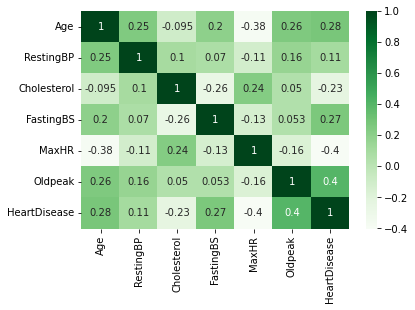

In [127]:
corr = df.corr()
sns.heatmap(corr, cmap='Greens', annot=True)

From the above heatmap we can see that there are no immediate correlations between the columns of our data.

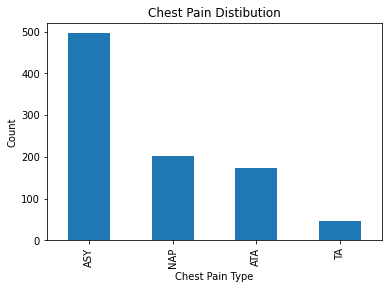

In [128]:
df_ml['ChestPainType'].value_counts().plot(kind='bar')
plt.xlabel("Chest Pain Type");
plt.ylabel("Count");
plt.title("Chest Pain Distibution");

From the above bar chart we can see the distibution of chest pain. We can see that ASY is the greatest and TA is the fewest. We will explore this in more detail later.

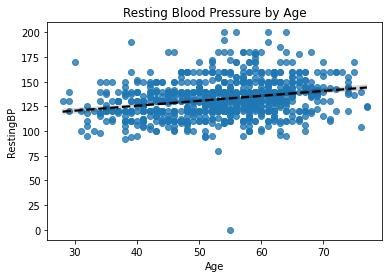

In [129]:
sns.regplot(data=df_ml, x='Age', y='RestingBP', line_kws={'color': 'black', 'ls': '--'});
plt.title("Resting Blood Pressure by Age");

We can see that most of the data points, when comparing Age and Resting Blood Pressure, are close with only a few exceptions. Another things to notice is that as Age increases Resting Blood Pressure also increases.

#Explanatory Visualization

From the graph below we can see that as a patient gets older thier chances of getting heart disease increase. (the shaded area in the grahp is confidence interval!!!!!!!!!!!!!)

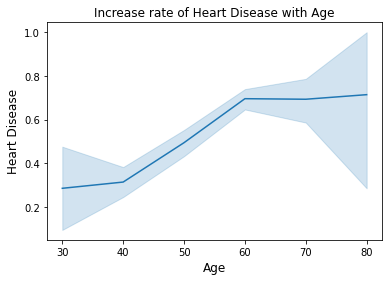

In [130]:
#Because we want a cleaner looking graph we need to round everyones age before we can graph agianst heart disease.
#To do this without ruining our original data set (which we will need later) lets first make a copy.
tempdf = df_ml.copy()

#Round everyones ages in the copied data frame
tempdf['Age'] = tempdf['Age'].round(-1) 

#Now lets plot ages and heart disease to see what we get
sns.lineplot(data=tempdf, x='Age', y='HeartDisease');
plt.title("Increase rate of Heart Disease with Age");
plt.xlabel("Age", fontsize=12);
plt.ylabel("Heart Disease", fontsize=12);

Lets get the precentage of heart disease based on gender.

Percentages


Sex
F    0.259067
M    0.631724
Name: HeartDisease, dtype: float64

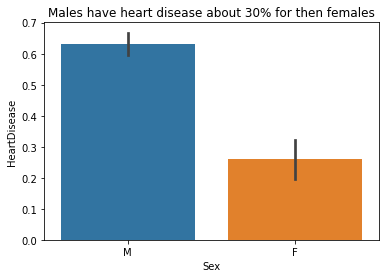

In [131]:
sns.barplot(data=df_ml, x='Sex', y='HeartDisease')
plt.title("Males have heart disease about 30% for then females");
print("Percentages")
df_ml.groupby('Sex').mean()['HeartDisease']

  From the graph below we can see that people who are asymptomatic in regards to chest pain, are more at risk. This makes sense because people who don't have any symptomes don't know that there is a problem that needs to be addressed. As a result, no preventative measures are taken which leads to a higher rate of positivity. One way to avoid this is have regular check ups and frequent testing.

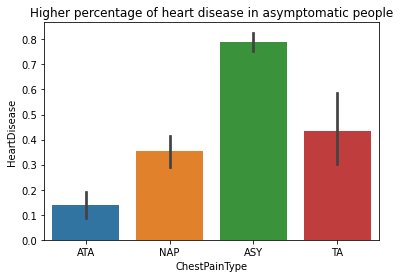

In [132]:
sns.barplot(data=df_ml, x='ChestPainType', y='HeartDisease')
plt.title("Higher percentage of heart disease in asymptomatic people");

The following graphs show that people who have exercise angina and a flat or down ST slope are more at risk of getting heart disease.

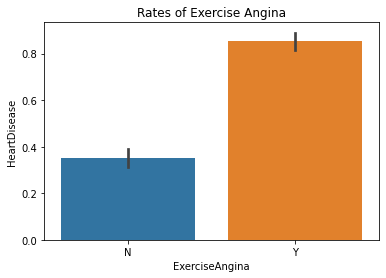

In [133]:
sns.barplot(data=df_ml, x='ExerciseAngina', y='HeartDisease');
plt.title("Rates of Exercise Angina");

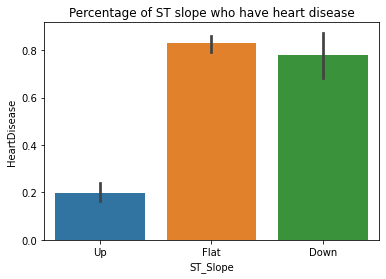

In [134]:
sns.barplot(data=df_ml, x='ST_Slope', y='HeartDisease');
plt.title("Percentage of ST slope who have heart disease");

#Data pre-processing

In [135]:
#We split our data into our features matrix and target column.
X = df_ml.drop(columns='HeartDisease')
y = df_ml['HeartDisease']

In [136]:
#Lets perform train/test split so we dont have any data leakage.
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

We need to scale the numerical columns and One Hot Encode the nominal columns.

In [137]:
#instantiate scaler
scaler = StandardScaler()

#instantiate One Hot Encoder
ohe = OneHotEncoder(handle_unknown='ignore')

#lets select our data by type
cat_selector = make_column_selector(dtype_include='object')
num_selector = make_column_selector(dtype_include='number')

#tuple these together with the appropriate transformer
num_tuple = (scaler, num_selector)
cat_tuple = (ohe, cat_selector)

#make a column transformer
transformer = make_column_transformer(cat_tuple, num_tuple, remainder='passthrough')

#fit the data
# transformer.fit(X_train, y_train)

Metrics Method : To make our code more readabl, lets make a method that will use all our metrics and apply them all at once.

In [138]:
def metric(y, pred):
  print("Accuracy score : ", accuracy_score(y, pred))
  print("Recall score : ", recall_score(y, pred)) 
  print("Precision score : ", precision_score(y, pred))
  print()
  print(classification_report(y, pred))

#Modeling

###We begin by using a default XGBClassifier

------------------Training Data Scores------------------
Accuracy score :  0.9331395348837209
Recall score :  0.9547872340425532
Precision score :  0.9252577319587629

              precision    recall  f1-score   support

           0       0.94      0.91      0.92       312
           1       0.93      0.95      0.94       376

    accuracy                           0.93       688
   macro avg       0.93      0.93      0.93       688
weighted avg       0.93      0.93      0.93       688


------------------Testing Data Scores------------------
Accuracy score :  0.8695652173913043
Recall score :  0.8484848484848485
Precision score :  0.9180327868852459

              precision    recall  f1-score   support

           0       0.81      0.90      0.85        98
           1       0.92      0.85      0.88       132

    accuracy                           0.87       230
   macro avg       0.87      0.87      0.87       230
weighted avg       0.87      0.87      0.87       230



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


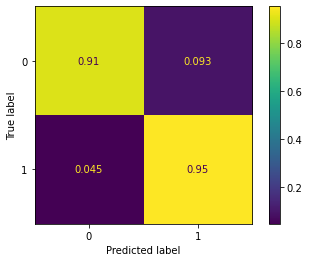

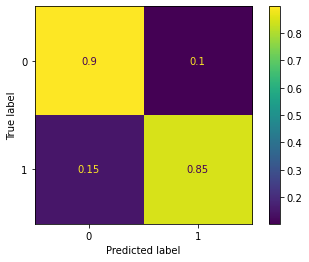

In [139]:
#instantiate basic model
xgb = XGBClassifier(random_state=42);

#put the model and the transformer in a pipeline
xgb_pipe = make_pipeline(transformer, xgb);

#fit the data
xgb_pipe.fit(X_train, y_train);

#make predictions
train_pred = xgb_pipe.predict(X_train);
test_pred = xgb_pipe.predict(X_test);

#evaluate
print("------------------Training Data Scores------------------")
metric(y_train, train_pred);
plot_confusion_matrix(xgb_pipe, X_train, y_train, normalize='true');
print("\n------------------Testing Data Scores------------------")
metric(y_test, test_pred);
plot_confusion_matrix(xgb_pipe, X_test, y_test, normalize='true');

Before analyzing the results, lets tune some of the parameters and compare which model did better.

We will use a grid search to tune multiple parameters at once.

In [149]:
%%time
# https://towardsdatascience.com/mastering-xgboost-2eb6bce6bc76
#Gridsearch
params = {'xgbclassifier__max_depth': [2,3,4],
          'xgbclassifier__num_leaves': [0,1,2],
          'xgbclassifier__learning_rate': [1, .1, .01], 
          'xgbclassifier__min_child_weight': [1, .1, .01],
          'xgbclassifier__n_estimators': [50, 75, 100]}

gridsearch = GridSearchCV(xgb_pipe, param_grid=params, scoring='f1')

gridsearch.fit(X_train, y_train)

print(gridsearch.best_params_)
# other metrics we can use to tune our model using gridsearch. https://login.codingdojo.com/m/213/7198/101240

{'xgbclassifier__learning_rate': 0.1, 'xgbclassifier__max_depth': 4, 'xgbclassifier__min_child_weight': 0.01, 'xgbclassifier__n_estimators': 50, 'xgbclassifier__num_leaves': 0}
CPU times: user 1min 17s, sys: 789 ms, total: 1min 18s
Wall time: 1min 20s


The output above shows the parameters and values for the best model. 
We will now extract the best model and see if the tuned model did better than our default model.

Lets use the best tuned model

------------------Training Data Scores------------------
Accuracy score :  0.9418604651162791
Recall score :  0.9574468085106383
Precision score :  0.9375

              precision    recall  f1-score   support

           0       0.95      0.92      0.94       312
           1       0.94      0.96      0.95       376

    accuracy                           0.94       688
   macro avg       0.94      0.94      0.94       688
weighted avg       0.94      0.94      0.94       688


-------------------Testing Data Scores-------------------
Accuracy score :  0.8782608695652174
Recall score :  0.8787878787878788
Precision score :  0.90625

              precision    recall  f1-score   support

           0       0.84      0.88      0.86        98
           1       0.91      0.88      0.89       132

    accuracy                           0.88       230
   macro avg       0.87      0.88      0.88       230
weighted avg       0.88      0.88      0.88       230



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


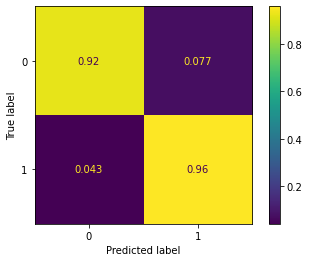

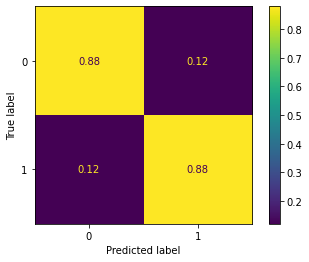

In [150]:
#Lets retireve and evaluate our best model
best_xgb = gridsearch.best_estimator_

#make predictions
train_preds = best_xgb.predict(X_train);
test_preds = best_xgb.predict(X_test);

#evaluate
print("------------------Training Data Scores------------------")
metric(y_train, train_preds);
plot_confusion_matrix(best_xgb, X_train, y_train, normalize='true');
print("\n-------------------Testing Data Scores-------------------")
metric(y_test, test_preds);
plot_confusion_matrix(best_xgb, X_test, y_test, normalize='true');

Our XGBClassier did slightly better than our default model. One major plus is that our recall score is higher which will be explained later on.

###Lets try a different model : Logistic Regression

We begin by using a default version of the model

------------------Training Data Scores------------------
Accuracy score :  0.8691860465116279
Recall score :  0.8962765957446809
Precision score :  0.8685567010309279

              precision    recall  f1-score   support

           0       0.87      0.84      0.85       312
           1       0.87      0.90      0.88       376

    accuracy                           0.87       688
   macro avg       0.87      0.87      0.87       688
weighted avg       0.87      0.87      0.87       688


-------------------Testing Data Scores-------------------
Accuracy score :  0.8608695652173913
Recall score :  0.8484848484848485
Precision score :  0.9032258064516129

              precision    recall  f1-score   support

           0       0.81      0.88      0.84        98
           1       0.90      0.85      0.88       132

    accuracy                           0.86       230
   macro avg       0.86      0.86      0.86       230
weighted avg       0.86      0.86      0.86       230



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


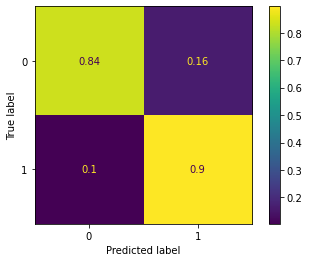

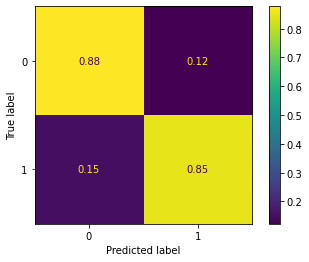

In [142]:
#instantiate model
log_reg = LogisticRegression(C=1000, random_state=42)

#make pipeline
pipe = make_pipeline(transformer, log_reg)

#fit the data
pipe.fit(X_train, y_train)

#make predictions
train_pred = pipe.predict(X_train)
test_pred = pipe.predict(X_test)

#evaluate
print("------------------Training Data Scores------------------")
metric(y_train, train_pred)
plot_confusion_matrix(pipe, X_train, y_train, normalize='true')
print("\n-------------------Testing Data Scores-------------------")
metric(y_test, test_pred)
plot_confusion_matrix(pipe, X_test, y_test, normalize='true')

Lets tune the model

In [143]:
%%time
#Gridsearch
params = {'logisticregression__C': [.125, .25, 1],
          'logisticregression__max_iter':[15],
          'logisticregression__penalty': ['l1', 'l2'], 
          'logisticregression__solver': ['liblinear']}

gridsearch = GridSearchCV(pipe, param_grid=params)

gridsearch.fit(X_train, y_train)

print(gridsearch.best_params_)

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


{'logisticregression__C': 0.25, 'logisticregression__max_iter': 15, 'logisticregression__penalty': 'l1', 'logisticregression__solver': 'liblinear'}
CPU times: user 711 ms, sys: 6.96 ms, total: 718 ms
Wall time: 725 ms


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


------------------Training Data Scores------------------
Accuracy score :  0.8706395348837209
Recall score :  0.8962765957446809
Precision score :  0.8708010335917312

              precision    recall  f1-score   support

           0       0.87      0.84      0.85       312
           1       0.87      0.90      0.88       376

    accuracy                           0.87       688
   macro avg       0.87      0.87      0.87       688
weighted avg       0.87      0.87      0.87       688


-------------------Testing Data Scores-------------------
Accuracy score :  0.8695652173913043
Recall score :  0.8560606060606061
Precision score :  0.9112903225806451

              precision    recall  f1-score   support

           0       0.82      0.89      0.85        98
           1       0.91      0.86      0.88       132

    accuracy                           0.87       230
   macro avg       0.87      0.87      0.87       230
weighted avg       0.87      0.87      0.87       230



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


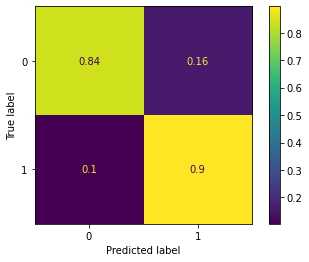

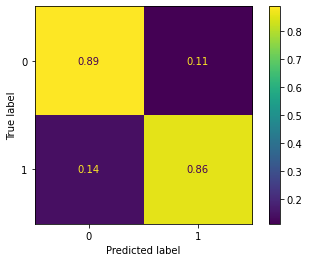

In [144]:
#Lets retireve and evaluate our best model
best_lr = gridsearch.best_estimator_

#make predictions
train_preds = best_lr.predict(X_train)
test_preds = best_lr.predict(X_test)

#evaluate
print("------------------Training Data Scores------------------")
metric(y_train, train_preds)
plot_confusion_matrix(best_lr, X_train, y_train, normalize='true')
print("\n-------------------Testing Data Scores-------------------")
metric(y_test, test_preds)
plot_confusion_matrix(best_lr, X_test, y_test, normalize='true')

Compared with XGBoosting, the logistic regression model performed almost as good.

#Feature engineering

Lets use Principal Component Analysis (PCA) to reduce the number of features we have to see if we can improve our testing scores.

In [151]:
#instantiate pipeline
pca_pipe = make_pipeline(transformer, PCA(n_components=.95))

#we can check the size of our original data set and compare it with the engineered dataset to see how many columns we have reduced
print("Original number of rows and columns")
display(transformer.fit_transform(X_train).shape)
print("Number of rows and columns after PCA")
display(pca_pipe.fit_transform(X_train).shape)

Original number of rows and columns


(688, 20)

Number of rows and columns after PCA


(688, 12)

Next we use a K-Nearest Neighbors Classifier to predict our target column using our reduced features matrix. 

Lets first tune the model.

In [157]:
max_recall = 0
k = 0;
for i in range(1,20):
  #instantiate model
  knn = KNeighborsClassifier(n_neighbors=i)

  #make another pipeline
  pipe = make_pipeline(pca_pipe, knn)

  #fit on the data
  pipe.fit(X_train, y_train)

  #make predictions
  test_predictions_pca = pipe.predict(X_test)

  #score using recall
  temp = recall_score(y_test, test_predictions_pca)

  if (temp > max_recall):
    max_recall = temp
    k = i

print("The max recall score that was generated was : ", max_recall, "\nThe k value is : ", k)

The max recall score that was generated was :  0.8863636363636364 
The k value is :  7


Lets now make a final model using the best k value.

------------------Training Data Scores------------------
Accuracy score :  0.8808139534883721
Recall score :  0.9122340425531915
Precision score :  0.875

              precision    recall  f1-score   support

           0       0.89      0.84      0.87       312
           1       0.88      0.91      0.89       376

    accuracy                           0.88       688
   macro avg       0.88      0.88      0.88       688
weighted avg       0.88      0.88      0.88       688


-------------------Testing Data Scores-------------------
Accuracy score :  0.8782608695652174
Recall score :  0.8863636363636364
Precision score :  0.9

              precision    recall  f1-score   support

           0       0.85      0.87      0.86        98
           1       0.90      0.89      0.89       132

    accuracy                           0.88       230
   macro avg       0.88      0.88      0.88       230
weighted avg       0.88      0.88      0.88       230



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


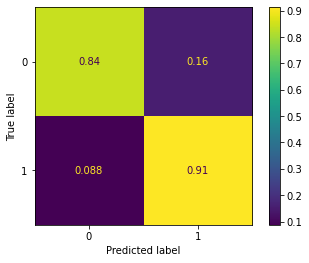

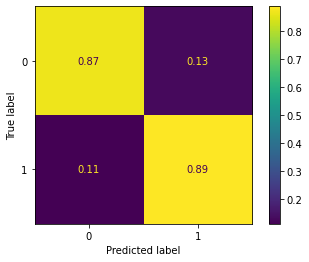

In [159]:
#instantiate best model
knn = KNeighborsClassifier(n_neighbors=7)

#put everything in our pipeline
pipe = make_pipeline(pca_pipe, knn)

#fit data
pipe.fit(X_train, y_train)

#make predictions using pca
train_predictions_pca = pipe.predict(X_train)
test_predictions_pca = pipe.predict(X_test)

#evaluate knn that uses pca
print("------------------Training Data Scores------------------")
metric(y_train, train_predictions_pca)
plot_confusion_matrix(pipe, X_train, y_train, normalize='true')
print("\n-------------------Testing Data Scores-------------------")
metric(y_test, test_predictions_pca)
plot_confusion_matrix(pipe, X_test, y_test, normalize='true')

  In this particular data set, we are trying to predict if a patient has heart disease. Lets identify the type of error that we are trying ovoid more. From what I know, it would be better to error on the side of caution and assume a patient has heart disease rather then makeing the mistake in predicting that the pateint does not. A patient who has heart disease and doesn't recieve treatment is at a much higher risk of fatality. Someone who is falsely predicted of having heart disease will most likely go through other tests and examinations which will indicate that they dont require any treatment.

  For this reason, the model I would choose to put forth in production is the model that scores the highest recall score. This will insure the lowest number of false negetives. This will avoid the worse outcome as much as possible. 
      
      Chosen Model: K-Nearest Neighbors Classifier
            -------------------Testing Data Scores-------------------
      Accuracy score :  0.8782608695652174
      Recall score :  0.8863636363636364
      Precision score :  0.9